# Introduction to Computer Vison Lab!

In lecture, we saw how to build an image classifier by attaching a head of dense layers to a pretrained base. The base we used was from a model called **VGG16**. We saw that the VGG16 architecture was prone to overfitting this dataset. You'll learn a number of ways you can improve upon this initial attempt.

First, we will try to use a different pre-trained base. The base this model comes from is called **InceptionV2** (also known as GoogLeNet). InceptionV1 was one of the early winners of the ImageNet competition. One of its successors, InceptionV4, is among the state of the art today.

To get started, run the cells below to set everything up.

## Setting Up the Workspace

In [1]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
import os, warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.preprocessing import image_dataset_from_directory

# Sympy is a python library for symbolic mathematics with a nice pretty printer for matrices.
import sympy
sympy.init_printing()
from IPython.display import display

from itertools import product, chain

# Reproducability
def set_seed(seed=42):
    tf.keras.utils.set_random_seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
#set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

## Loading the Data

Source: https://universe.roboflow.com/larry-motalavigne/package-and-label-detector

In [2]:
!wget -O data.zip https://www.dropbox.com/s/euu87khtt0vujrb/Package%20and%20label%20detector.v3i.tfrecord.zip?dl=1
!unzip -o data.zip

--2023-04-21 12:00:49--  https://www.dropbox.com/s/euu87khtt0vujrb/Package%20and%20label%20detector.v3i.tfrecord.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/euu87khtt0vujrb/Package%20and%20label%20detector.v3i.tfrecord.zip [following]
--2023-04-21 12:00:49--  https://www.dropbox.com/s/dl/euu87khtt0vujrb/Package%20and%20label%20detector.v3i.tfrecord.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc66b3d942ed96f7228f9a1753de.dl.dropboxusercontent.com/cd/0/get/B6mgrE9cKVdeIF0jnL6HCdU4fg0a7qY_U1O8u9JQ5TCYZIUh7g1p3FxYWRUS1qBs2rK1uDVKBM6xh0OQa31H0RiHlH5pdnSSEHDFCHVPvRqzJ8pPyR0rw2pjMbw4gFcC5hkkuF-pDFIz8wAXBRa8gP2pSfpOvgsVzBtoNtX9H2_mQoYnOce0RMxeFIo6xORAF4k/file?dl=1# [following]
--2023-04-21 12:00:50--  https://uc66b3d942

In [3]:
# Define the input function
def read_tf_records(tfrecord_path, batch_size):
    # Create a TFRecordDataset object
    dataset = tf.data.TFRecordDataset(tfrecord_path)

    # Define the feature description
    feature_description = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }

    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/text': tf.io.VarLenFeature(tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
    }


    # Parse the record into tensors
    def _parse_function(example_proto):
        return tf.io.parse_single_example(example_proto, feature_description)

    # Apply the parse function to every record
    dataset = dataset.map(_parse_function)
    # Decode the image
    def decode_image(record):
        image = tf.image.decode_jpeg(record['image/encoded'], channels=3)
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.image.resize(image, (224, 224))
        image = tf.reshape(image, [-1, 224, 224, 3])
        label = tf.sparse.to_dense(record['image/object/class/label'])
        #Convert label into binary classification whether the box has a label
        label = tf.maximum(0, tf.reduce_max(tf.cast(tf.math.equal(label, 1), tf.int32)))
        label = tf.reshape(label, (-1,1))
        return image, label

    # Apply the decode_image function to every record
    dataset = dataset.map(decode_image)

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    # Return the dataset
    return dataset

ds_train = read_tf_records('train/Package-and-label.tfrecord',128)

ds_valid = read_tf_records('valid/Package-and-label.tfrecord',128)

ds_test = read_tf_records('test/Package-and-label.tfrecord',128)

In [4]:
has_label = 0
no_label = 0
for (record, label) in ds_test.take(50000):
  if label[0][0] == 1:
    has_label += 1
  elif label[0][0] == 0:
    no_label += 1

print (f"Has Label {has_label}, no lable {no_label}")

Has Label 44, no lable 49


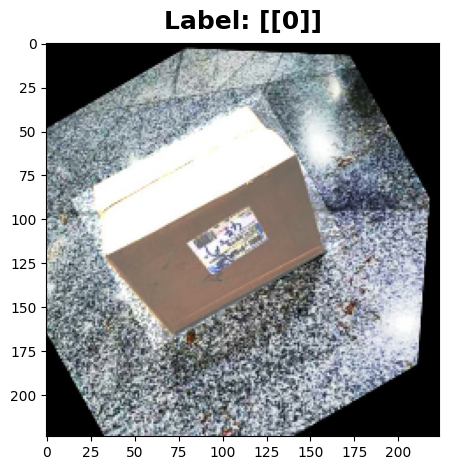

In [5]:
ds_iter = iter(ds_train)
image, label = next(ds_iter)

# Plot the image
plt.imshow(image.numpy()[0])
plt.title(f"Label: {label}")
plt.show()

In [6]:
if False:
 for i in range(5):
  image, label = next(ds_iter)

  # Plot the image
  plt.imshow(image.numpy()[0])
  plt.title(f"Label: {label}")
  plt.show()

---
# Lab Exercise 1. *Transfer Learning with Inception*

The **Inception** model pretrained on ImageNet is included in TensorFlow. Run this cell to load Inception for your base.

In [8]:
pretrained_base = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

219055592/219055592 [==============================] - 2s 0us/step


## 1) Define Pretrained Base

Now that you have a pretrained base to do our feature extraction, decide whether this base should be trainable or not.

In [9]:
# YOUR_CODE_HERE
# Indicate whether this base should be trainable or not

pretrained_base.trainable = False



In [10]:
pretrained_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

## 2) Attach Head

Now that the base is defined to do the feature extraction, create a head of `Dense` layers to perform the classification, following this diagram:

<figure>
<img src="https://i.imgur.com/NSyGvEX.png" alt="Diagram of the dense head.">
</figure>


In [13]:
# YOUR_CODE_HERE
# Create a head of Dense layers to perform the classification

model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(32,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])



## 3) Train

Before training a model in Keras, you need to specify an *optimizer* to perform the gradient descent, a *loss function* to be minimized, and (optionally) any *performance metrics*. The optimization algorithm we'll use for this course is called ["Adam"](https://keras.io/api/optimizers/adam/), which generally performs well regardless of what kind of problem you're trying to solve.

The loss and the metrics, however, need to match the kind of problem you're trying to solve. Our problem is a **binary classification** problem: `No label` coded as 0, and `Has Label` coded as 1. Choose an appropriate loss and an appropriate accuracy metric for binary classification.

In [19]:
# YOUR CODE HERE
# What loss function and metrics should you use for a *binary* classification problem? 

optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics = ['binary_accuracy']
)



In [20]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    callbacks=[early_stopping],
)

Epoch 1/30
1635/1635 [==============================] - 76s 30ms/step - loss: 0.9820 - binary_accuracy: 0.7278 - val_loss: 0.4280 - val_binary_accuracy: 0.8146
Epoch 2/30
1635/1635 [==============================] - 47s 29ms/step - loss: 0.3805 - binary_accuracy: 0.8489 - val_loss: 0.4807 - val_binary_accuracy: 0.8013
Epoch 3/30
1635/1635 [==============================] - 44s 27ms/step - loss: 0.2646 - binary_accuracy: 0.9046 - val_loss: 0.5071 - val_binary_accuracy: 0.8079
Epoch 4/30
1635/1635 [==============================] - 44s 27ms/step - loss: 0.2216 - binary_accuracy: 0.9064 - val_loss: 0.7116 - val_binary_accuracy: 0.7682
Epoch 5/30
1635/1635 [==============================] - 44s 27ms/step - loss: 0.1681 - binary_accuracy: 0.9309 - val_loss: 0.6941 - val_binary_accuracy: 0.8079
Epoch 6/30
1635/1635 [==============================] - 44s 27ms/step - loss: 0.1082 - binary_accuracy: 0.9523 - val_loss: 0.6658 - val_binary_accuracy: 0.8278
Epoch 7/30
1635/1635 [==================

## 4) Examine Loss and Accuracy

Run the cell below to plot the loss and metric curves for this training run.

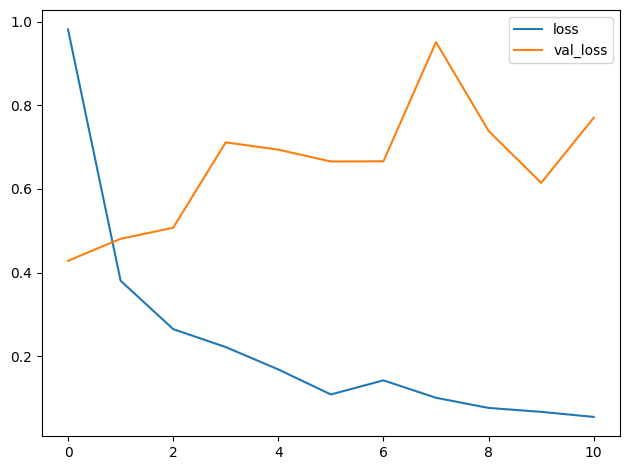

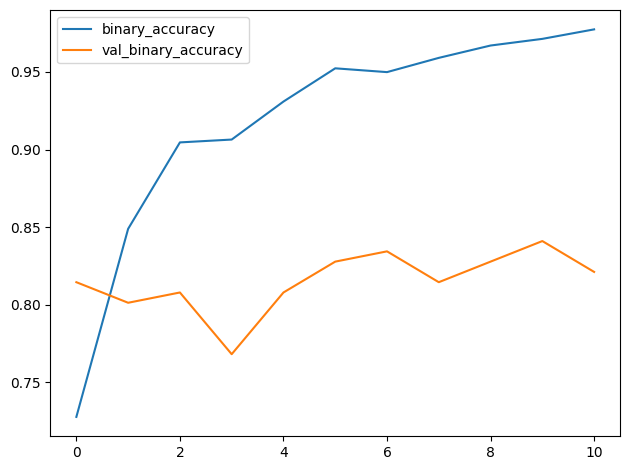

In [21]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [22]:
test_loss, test_acc = model.evaluate(ds_test, verbose=2)

print('\nTest accuracy:', test_acc)

93/93 - 2s - loss: 0.3859 - binary_accuracy: 0.8172 - 2s/epoch - 22ms/step

Test accuracy: 0.8172042965888977


In [23]:
predictions = model.predict(ds_test)

93/93 [==============================] - 5s 22ms/step


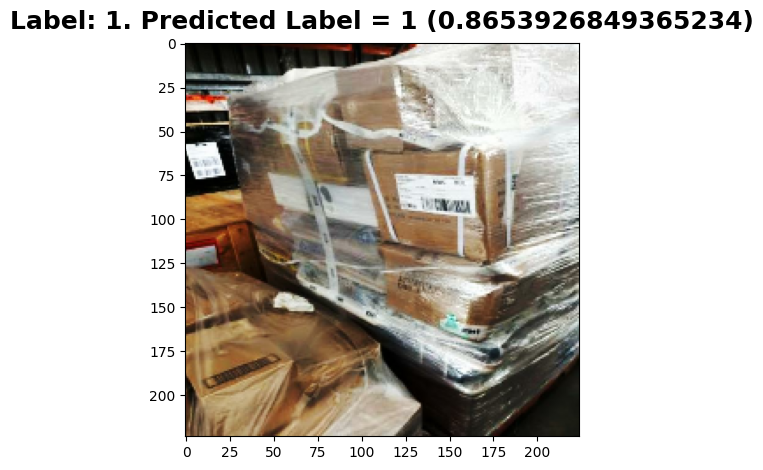

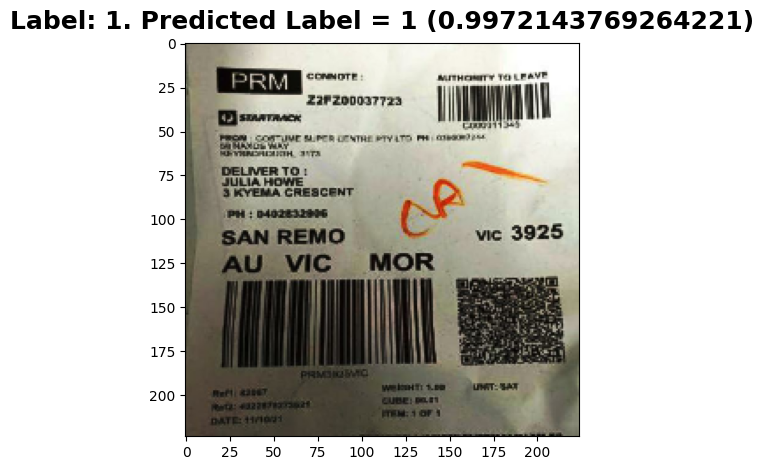

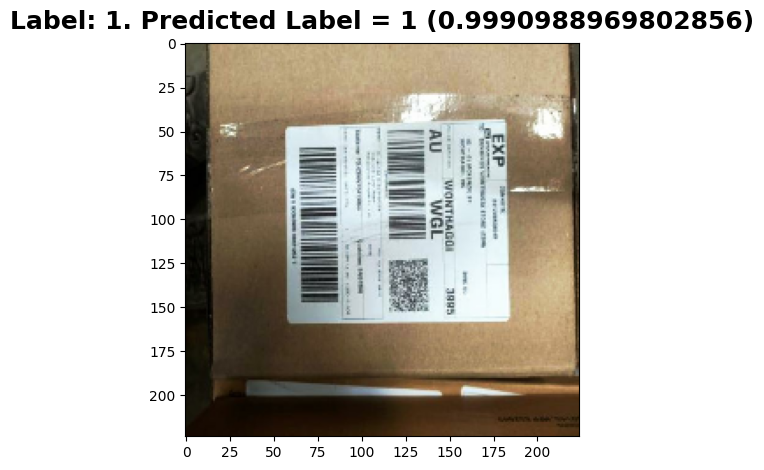

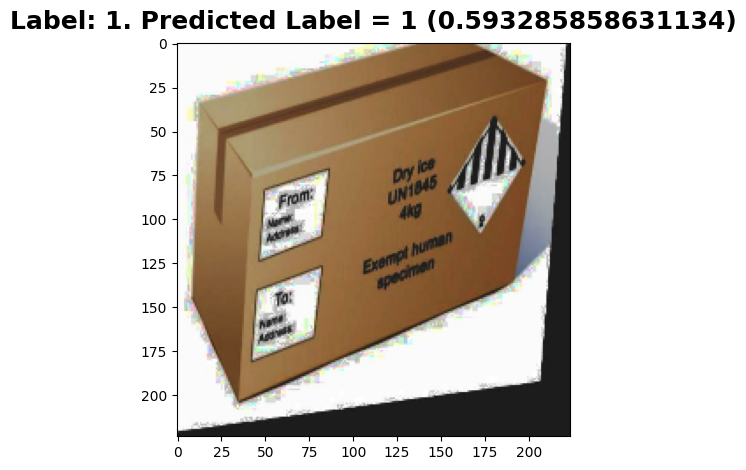

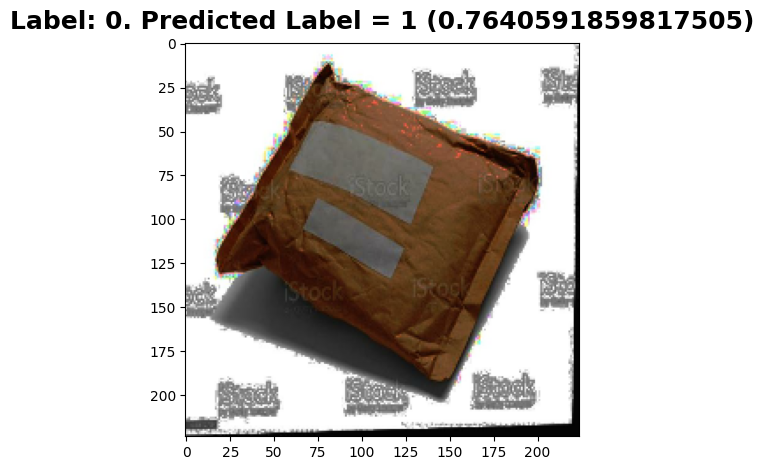

In [24]:
for pred, (image, label) in zip(predictions, ds_test.take(5)):
  has_label = round(pred[0])
  plt.imshow(image.numpy()[0])
  plt.title(f"Label: {label[0][0]}. Predicted Label = {has_label} ({pred[0]})")
  plt.show()

### Q: *Do you notice a difference between these learning curves and the curves for VGG16 from lecture? What does this difference tell you about what the model with Inception learned compared to VGG16? Are there ways in which one is better than the other? Worse?*

Please explain your answer in the empty cell below.


Answer: Yes. First of all the number of epochs we ran was less, thus we could not see the trend. However there is a lot of similarity as the trainig loss keeps decreasing as expected. However the valdiation loss for us keeps increasing suggesting that the model is not good or overfitting the training set. Even then the accuray is good. 



## Take-Away

In this first exercise, you learned the basics of **convolutional image classifiers**, that they consist of a **base** for extracting features from images, and a **head** which uses the features to decide the image's class. You also saw how to build a classifier with **transfer learning** on pretrained base. 

---
# Lab Exercise 2. *Convolution and ReLU*

In this exercise we will walk through feature extraction just like the example in lecture. Run the following cell to load an image we'll use for the next few questions.


In [25]:
!curl https://i.imgur.com/GvRI0Td.jpg > box_photo.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  125k  100  125k    0     0  4064k      0 --:--:-- --:--:-- --:--:-- 4064k


In [26]:
# PREDEFINED KERNELS #

# Edge detection
edge = tf.constant(
    [[-1, -1, -1],
     [-1, 8, -1],
     [-1, -1, -1]],
)

# Blur
blur = tf.constant(
    [[0.0625, 0.125, 0.0625],
     [0.125, 0.25, 0.125],
     [0.0625, 0.125, 0.0625]],
)

# Bottom sobel
bottom_sobel = tf.constant(
    [[-1, -2, -1],
     [0, 0, 0],
     [1, 2, 1]],
)

# Emboss South-East
emboss = tf.constant(
    [[-2, -1, 0],
     [-1, 1, 1],
     [0, 1, 2]],
)

# Sharpen
sharpen = tf.constant(
    [[0, -1, 0],
     [-1, 5, -1],
     [0, -1, 0]],
)

def show_kernel(kernel, label=True, digits=None, text_size=28):
    # Format kernel
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits)

    # Plot kernel
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max()+kernel.min())/2
    # Optionally, add value labels
    if label:
        for i, j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val, 
                     color=color, size=text_size,
                     horizontalalignment='center', verticalalignment='center')
    plt.xticks([])
    plt.yticks([])

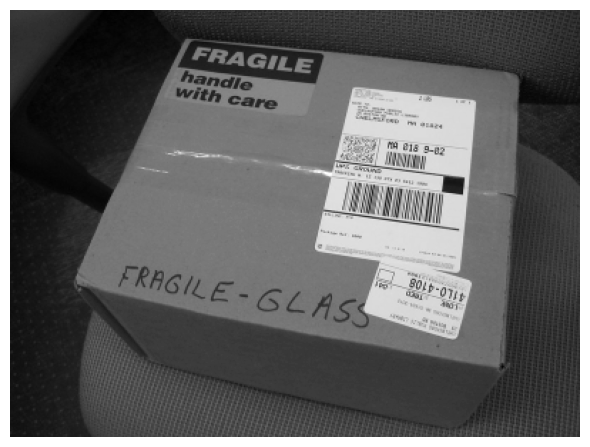

In [39]:
image_path = 'box_photo.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image, channels=1)
image = tf.image.resize(image, size=[300, 400])

img = tf.squeeze(image).numpy()
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show();

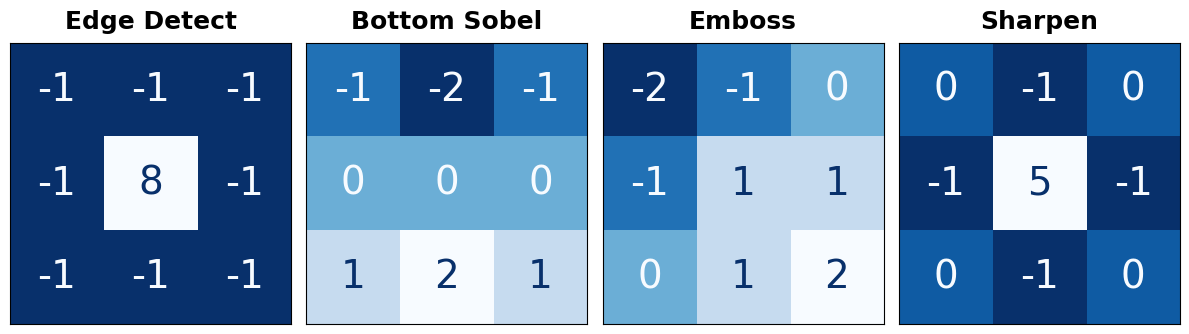

In [40]:
kernels = [edge, bottom_sobel, emboss, sharpen]
names = ["Edge Detect", "Bottom Sobel", "Emboss", "Sharpen"]

plt.figure(figsize=(12, 12))
for i, (kernel, name) in enumerate(zip(kernels, names)):
    plt.subplot(1, 4, i+1)
    show_kernel(kernel)
    plt.title(name)
plt.tight_layout()

## 1) Define Kernel 

Use the next code cell to define a kernel. You have your choice of what kind of kernel to apply. One thing to keep in mind is that the *sum* of the numbers in the kernel determines how bright the final image is. Generally, you should try to keep the sum of the numbers between 0 and 1 (though that's not required for a correct answer).

In general, a kernel can have any number of rows and columns. For this exercise, let's use a $3 \times 3$ kernel, which often gives the best results. Define an Emboss kernel with `tf.constant`.

In [50]:
# YOUR CODE HERE: 
# Define an Emboss kernel with 3 rows and 3 columns.

kernel = tf.constant(
    [[-1, 0, 1],
     [-1, 0, 1],
     [-1, 0, 1]],
)

Next we'll do the first step of feature extraction, the filtering step. Run this cell first to do some reformatting for TensorFlow.

In [51]:
# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

## 2) Apply Convolution to Filter Features

Now we'll apply the kernel to the image by a convolution. The *layer* in Keras that does this is `layers.Conv2D`. What is the *function* in TensorFlow that performs the same operation?

In [52]:
# YOUR CODE HERE
# Give the TensorFlow convolution function (without arguments)

conv_fn = tf.nn.conv2d

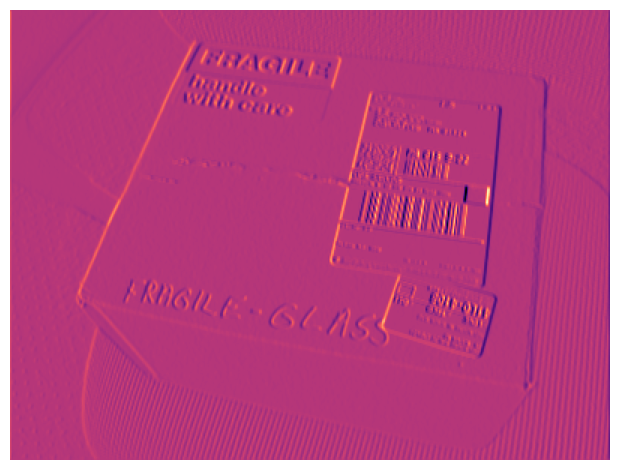

In [53]:
image_filter = conv_fn(
    input=image,
    filters=kernel,
    strides=1, # or (1, 1)
    padding='SAME',
)

plt.imshow(
    # Reformat for plotting
    tf.squeeze(image_filter)
)
plt.axis('off')
plt.show();

### Q: *Can you see how the kernel you chose relates to the feature map it produced?*

Please explain your answer in the empty cell below.

Answer: Yes. by changing the different values in the kernel or filter, i am able to extract many information from the picture. i varied the numbers and could see that the colors or hue were able to be extracted

## 3) Apply ReLU to Detect Features

Now detect the feature with the ReLU function. In Keras, you'll usually use this as the activation function in a `Conv2D` layer. What is the *function* in TensorFlow that does the same thing?

In [54]:
# YOUR CODE HERE
# Give the TensorFlow ReLU function (without arguments)

relu_fn = tf.nn.relu

Once you've got the solution, run this cell to detect the feature with ReLU and see the result!

The image you see below is the feature map produced by the kernel you chose. If you like, experiment with some of the other suggested kernels above, or, try to invent one that will extract a certain kind of feature.


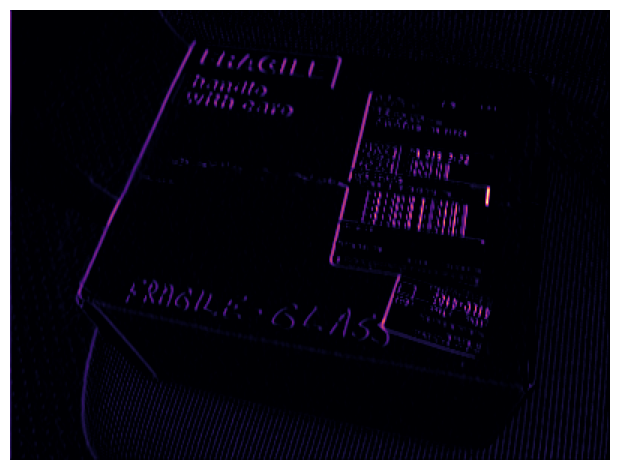

In [55]:
image_detect = relu_fn(image_filter)

plt.imshow(
    # Reformat for plotting
    tf.squeeze(image_detect)
)
plt.axis('off')
plt.show();

## 4) Observe Convolution on a Numerical Matrix 

In the tutorial, our discussion of kernels and feature maps was mainly visual. We saw the effect of `Conv2D` and `ReLU` by observing how they transformed some example images.

But the operations in a convolutional network (like in all neural networks) are usually defined through mathematical functions, through a computation on numbers. In the next exercise, we'll take a moment to explore this point of view.

Let's start by defining a simple array to act as an image, and another array to act as the kernel. Run the following cell to see these arrays.

In [58]:

image = np.array([
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 1, 1, 1],
    [0, 1, 0, 0, 0, 0],
])

kernel = np.array([
    [1, -1],
    [1, -1],
])

display(sympy.Matrix(image))
display(sympy.Matrix(kernel))

# Reformat for Tensorflow
image = tf.cast(image, dtype=tf.float32)
image = tf.reshape(image, [1, *image.shape, 1])
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)


⎡0  1  0  0  0  0⎤
⎢                ⎥
⎢0  1  0  0  0  0⎥
⎢                ⎥
⎢0  1  0  0  0  0⎥
⎢                ⎥
⎢0  1  0  0  0  0⎥
⎢                ⎥
⎢0  1  0  1  1  1⎥
⎢                ⎥
⎣0  1  0  0  0  0⎦

⎡1  -1⎤
⎢     ⎥
⎣1  -1⎦

### Q: *What do you see: What is the image? What about the kernel? What effect do you think the kernel will have on this image?*

Please explain your answer in the empty cell below.

Answer: I beleive this will detect the vertical lins in the image. In this case the output must have only the columsn which is 1 and others is 0. 

Now let's try it out. Run the next cell to apply convolution and ReLU to the image and display the result.

In [59]:
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1,
    padding='VALID',
)
image_detect = tf.nn.relu(image_filter)

# The first matrix is the image after convolution, and the second is
# the image after ReLU.
display(sympy.Matrix(tf.squeeze(image_filter).numpy()))
display(sympy.Matrix(tf.squeeze(image_detect).numpy()))

⎡-2.0  2.0   0    0  0⎤
⎢                     ⎥
⎢-2.0  2.0   0    0  0⎥
⎢                     ⎥
⎢-2.0  2.0   0    0  0⎥
⎢                     ⎥
⎢-2.0  2.0  -1.0  0  0⎥
⎢                     ⎥
⎣-2.0  2.0  -1.0  0  0⎦

⎡0  2.0  0  0  0⎤
⎢               ⎥
⎢0  2.0  0  0  0⎥
⎢               ⎥
⎢0  2.0  0  0  0⎥
⎢               ⎥
⎢0  2.0  0  0  0⎥
⎢               ⎥
⎣0  2.0  0  0  0⎦

### Q: *Is the result what you expected?*

Please explain your answer in the empty cell below.

Answer: Here as explaiend earlier , the straight vertical lines are detected and in the image only those are retained. 

## Take-Away

In this exercise, you learned about the first two operations a convolutional classifier uses for feature extraction: **filtering** an image with a *convolution* and **detecting** the feature with the *Rectified Linear Unit* (ReLU). 

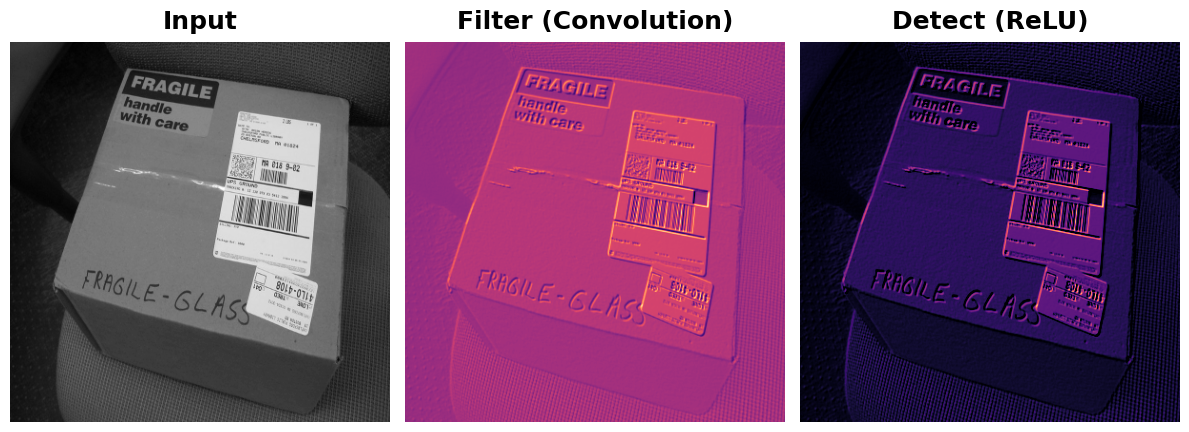

In [60]:
image_path = 'box_photo.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image, channels=1)
image = tf.image.resize(image, size=[400, 400])

# Embossing kernel
kernel = tf.constant([
    [-2, -1, 0],
    [-1, 1, 1],
    [0, 1, 2],
])

# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1,
    padding='VALID',
)

image_detect = tf.nn.relu(image_filter)

# Show what we have so far
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.title('Input')
plt.subplot(132)
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.title('Filter (Convolution)')
plt.subplot(133)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title('Detect (ReLU)')
plt.show();


In the next exercise, we will learn the final operation: **condensing** the feature map with *maximum pooling*!

---
# Lab Exercise 3. *Maximum Pooling*

## 1) Apply Pooling to Condense Features

For the last step in the sequence, apply maximum pooling using a $2 \times 2$ pooling window with stride 2. Use padding in order to keep the input and output the same size, so you don't lose information around the edges.

In [61]:
# YOUR CODE HERE:

image_condense = tf.nn.pool(
    input=image_detect,
    window_shape=(2, 2),
    pooling_type="MAX",
    strides = (2,2),
    padding='SAME'
)


Run the next cell to see what maximum pooling did to the feature!

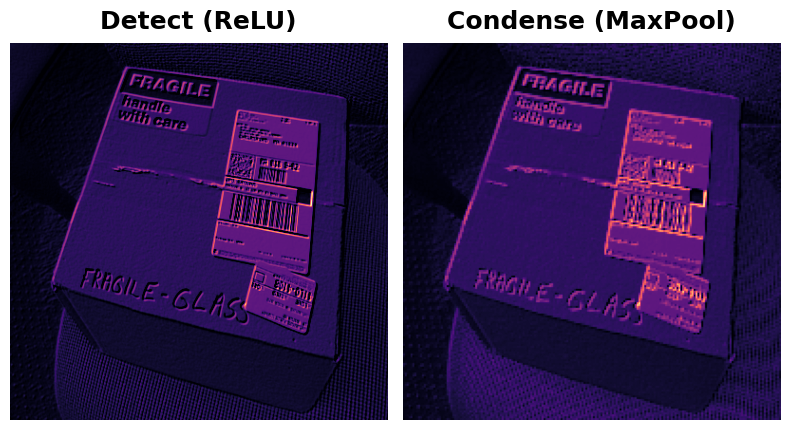

In [62]:
plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title("Detect (ReLU)")
plt.subplot(122)
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.title("Condense (MaxPool)")
plt.show();

## 2) Explore Invariance

`MaxPool2D` layers give a convolutional network the property of **translation invariance** over small distances. In this question, you will observe this in action.

### Code for drawing

In [63]:
from skimage import draw, transform
import math
# adapted from https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image/affine_transformations.py
# MIT License: https://github.com/keras-team/keras-preprocessing/blob/master/LICENSE

@tf.function
def _get_inverse_affine_transform(theta, tx, ty, shear, zx, zy):
    """ Construct the inverse of the affine transformation matrix with the given transformations. 
        The transformation is taken with respect to the usual right-handed coordinate system."""

    transform_matrix = tf.eye(3, dtype=tf.float32)

    if theta != 0:
        theta = theta * math.pi / 180 # convert degrees to radians
        # this is 
        rotation_matrix = tf.convert_to_tensor(
            [[tf.math.cos(theta), tf.math.sin(theta), 0],
             [-tf.math.sin(theta), tf.math.cos(theta), 0],
             [0, 0, 1]],
            dtype=tf.float32)
        transform_matrix = rotation_matrix

    if tx != 0 or ty != 0:
        shift_matrix = tf.convert_to_tensor(
            [[1, 0, -tx],
             [0, 1, -ty],
             [0, 0, 1]],
            dtype=tf.float32)
        if transform_matrix is None:
            transform_matrix = shift_matrix
        else:
            transform_matrix = tf.matmul(transform_matrix, shift_matrix)

    if shear != 0:
        shear = shear * math.pi / 180 # convert degrees to radians
        shear_matrix = tf.convert_to_tensor(
            [[1, tf.math.sin(shear), 0],
             [0, tf.math.cos(shear), 0],
             [0, 0, 1]],
            dtype=tf.float32)
        if transform_matrix is None:
            transform_matrix = shear_matrix
        else:
            transform_matrix = tf.matmul(transform_matrix, shear_matrix)

    if zx != 1 or zy != 1:
        # need to assert !=0
        zoom_matrix = tf.convert_to_tensor(
            [[1/zx, 0, 0],
             [0, 1/zy, 0],
             [0, 0, 1]],
            dtype=tf.float32)
        if transform_matrix is None:
            transform_matrix = zoom_matrix
        else:
            transform_matrix = tf.matmul(transform_matrix, zoom_matrix)
            
    return transform_matrix

@tf.function
def _apply_inverse_affine_transform(A, Ti, fill_method, interpolation_method):
    """Perform an affine transformation of the image A defined by a
transform whose inverse is Ti. The matrix Ti is assumed to be in
homogeneous coordinate form.
    Available fill methods are "replicate" and "reflect" (default).
    Available interpolation method is "nearest".
    """
    nrows, ncols, _ = A.shape

    # Create centered coordinate grid
    x = tf.range(ncols*nrows) % ncols
    x = tf.cast(x, dtype=tf.float32) - ((ncols-1)/2) # center
    y = tf.range(ncols*nrows) // ncols
    y = tf.cast(y, dtype=tf.float32) - ((nrows-1)/2) # center
    y = -y # left-handed to right-handed coordinates
    z = tf.ones([ncols*nrows], dtype=tf.float32)
    grid = tf.stack([x, y, z])

    # apply transformation
    # x, y, _ = tf.matmul(Ti, grid)
    xy = tf.matmul(Ti, grid)
    x = xy[0, :]
    y = xy[1, :]
    
    # convert coordinates to (approximate) indices
    i = -y + ((nrows-1)/2)
    j = x + ((ncols-1)/2)

    # replicate: 111|1234|444
    if fill_method is 'replicate':
        i = tf.clip_by_value(i, 0.0, nrows-1)
        j = tf.clip_by_value(j, 0.0, ncols-1)
    # reflect: 432|1234|321
    elif fill_method is 'reflect':
        i = _reflect_index(i, nrows-1)
        j = _reflect_index(j, ncols-1)
        
    # nearest neighbor interpolation
    grid = tf.stack([i, j])
    grid = tf.round(grid)
    grid = tf.cast(grid, dtype=tf.int32)
    B = tf.gather_nd(A, tf.transpose(grid))
    B = tf.reshape(B, A.shape)

    return B

def circle(size, val=None, r_shrink=0):
    circle = np.zeros([size[0]+1, size[1]+1])
    rr, cc = draw.circle_perimeter(
        size[0]//2, size[1]//2,
        radius=size[0]//2 - r_shrink,
        shape=[size[0]+1, size[1]+1],
    )
    if val is None:
        circle[rr, cc] = np.random.uniform(size=circle.shape)[rr, cc]
    else:
        circle[rr, cc] = val
    circle = transform.resize(circle, size, order=0)
    return circle

@tf.function
def apply_affine_transform(x,
                           theta=0, tx=0, ty=0, shear=0, zx=1, zy=1,
                           row_axis=0, col_axis=1, channel_axis=2,
                           fill_method='reflect', cval=0.,
                           interpolation_method='nearest'):
    """ Apply an affine transformation to an image x. """

    theta = tf.convert_to_tensor(theta, dtype=tf.float32)
    tx = tf.convert_to_tensor(tx, dtype=tf.float32)
    ty = tf.convert_to_tensor(ty, dtype=tf.float32)
    shear = tf.convert_to_tensor(shear, dtype=tf.float32)
    zx = tf.convert_to_tensor(zx, dtype=tf.float32)
    zy = tf.convert_to_tensor(zy, dtype=tf.float32)

    transform_matrix = _get_inverse_affine_transform(
        theta,
        tx, ty,
        shear,
        zx, zy,
    )

    x = _apply_inverse_affine_transform(
        x,
        transform_matrix,
        fill_method=fill_method,
        interpolation_method=interpolation_method,
    )

    return x

@tf.function
def random_transform(image, jitter=0, rotate=0, scale=1, **kwargs):
    jx = tf.random.uniform([], -jitter, jitter)
    jy = tf.random.uniform([], -jitter, jitter)
    r = tf.random.uniform([], -rotate, rotate)
    s = tf.random.uniform([], 1.0, scale)
    image = apply_affine_transform(
        image,
        theta=r,
        tx=jx, ty=jy,
        zx=s, zy=s,
        **kwargs,
    )
    return image

def fft_scale(h, w, decay_power=1.0):
    freqs = rfft2d_freqs(h, w)
    scale = 1.0 / np.maximum(freqs, 1.0 / max(w, h)) ** decay_power
    scale *= np.sqrt(w * h)
    return tf.convert_to_tensor(scale, dtype=tf.complex64)

def init_buffer(height, width=None, batches=1, channels=3, scale=0.01, fft=True):
    """Initialize an image buffer."""
    width = width or height
    shape = [batches, height, width, channels]
    fn = init_fft if fft else init_pixel
    
    buffer = fn(shape, scale)
    
    return tf.Variable(buffer, trainable=True)

def fft_to_rgb(shape, buffer, fft_scale):
    """Convert FFT spectrum buffer to RGB image buffer."""
    
    batch, h, w, ch = shape

    spectrum = tf.complex(buffer[0], buffer[1]) * fft_scale
    image = tf.signal.irfft2d(spectrum)
    image = tf.transpose(image, (0, 2, 3, 1))
    
    # in case of odd spatial input dimensions we need to crop
    image = image[:batch, :h, :w, :ch]
    image = image / 4.0  # TODO: is that a magic constant?
    
    return image

def to_valid_rgb(image, crop=False):
    if crop:
        image = image[:, 25:-25, 25:-25, :]
    image = correlate_color(image)
    image = tf.nn.sigmoid(image)
    return image

def correlate_color(image):
    image_flat = tf.reshape(image, [-1, 3])
    image_flat = tf.matmul(image_flat, color_correlation_normalized.T)
    image = tf.reshape(image_flat, tf.shape(image))
    return image

# Adapted from https://github.com/tensorflow/lucid/blob/master/lucid/optvis/param/spatial.py
# and https://github.com/elichen/Feature-visualization/blob/master/optvis.py
def rfft2d_freqs(h, w):
    """Computes 2D spectrum frequencies."""

    fy = np.fft.fftfreq(h)[:, np.newaxis]
    # when we have an odd input dimension we need to keep one additional
    # frequency and later cut off 1 pixel
    if w % 2 == 1:
        fx = np.fft.fftfreq(w)[: w // 2 + 2]
    else:
        fx = np.fft.fftfreq(w)[: w // 2 + 1]
        
    return np.sqrt(fx * fx + fy * fy)

# Color Transforms #
color_correlation_svd_sqrt = np.asarray(
    [[0.26, 0.09, 0.02],
     [0.27, 0.00, -0.05],
     [0.27, -0.09, 0.03]]
).astype("float32")
max_norm_svd_sqrt = np.max(np.linalg.norm(color_correlation_svd_sqrt, axis=0))
color_correlation_normalized = color_correlation_svd_sqrt / max_norm_svd_sqrt
color_mean = np.asarray([0.485, 0.456, 0.406])
color_std = np.asarray([0.229, 0.224, 0.225])


def random_map(size, scale=0.5, decay_power=1.0):
    h, w = size
    shape = [1, h, w, 3]
    fft = fft_scale(h, w, decay_power=decay_power)
    img = init_buffer(h, w, scale=scale)
    img = fft_to_rgb(shape, img, fft)
    img = to_valid_rgb(img)
    img = img[0,:,:,0]
    return img

def init_fft(shape, scale=0.1):
    """Initialize FFT image buffer."""
    
    batch, h, w, ch = shape
    freqs = rfft2d_freqs(h, w)
    init_val_size = (2, batch, ch) + freqs.shape

    buffer = np.random.normal(size=init_val_size, scale=scale).astype(np.float32)
    return buffer


This next code cell will randomly apply a small shift to a circle and then condense the image several times with maximum pooling. Run the cell once and make note of the image that results at the end.

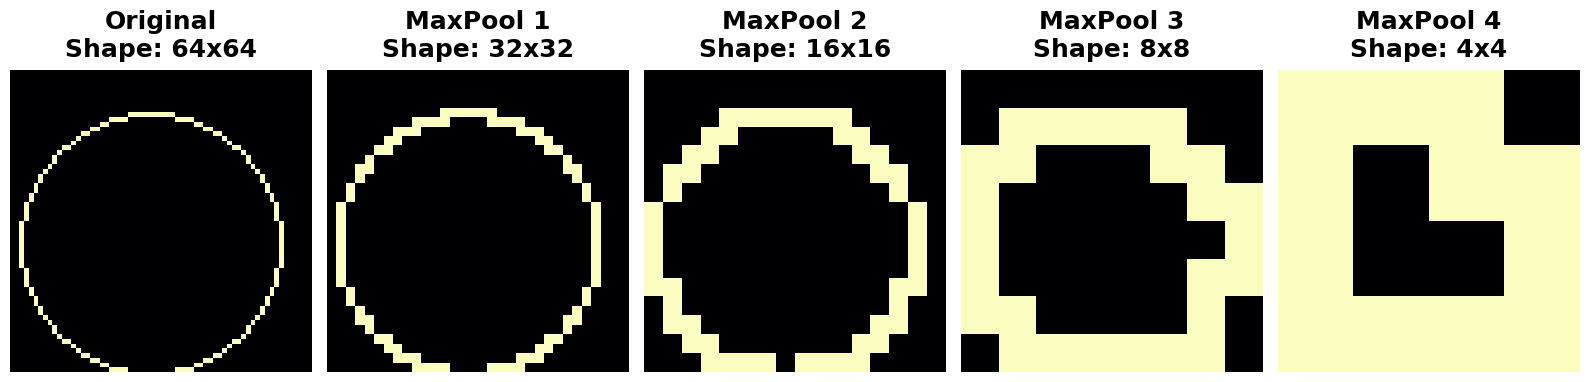

In [65]:
REPEATS = 4
SIZE = [64, 64]


# Create a randomly shifted circle
image = circle(SIZE, r_shrink=4, val=1)
image = tf.expand_dims(image, axis=-1)
image = random_transform(image, jitter=5, fill_method='replicate')
image = tf.squeeze(image)

plt.figure(figsize=(16, 4))
plt.subplot(1, REPEATS+1, 1)
plt.imshow(image, vmin=0, vmax=1)
plt.title("Original\nShape: {}x{}".format(image.shape[0], image.shape[1]))
plt.axis('off')

# Now condense with maximum pooling several times
for i in range(REPEATS):
    ax = plt.subplot(1, REPEATS+1, i+2)
    image = tf.reshape(image, [1, *image.shape, 1])
    image = tf.nn.pool(image, window_shape=(2,2), strides=(2, 2), padding='SAME', pooling_type='MAX')
    image = tf.squeeze(image)
    plt.imshow(image, vmin=0, vmax=1)
    plt.title("MaxPool {}\nShape: {}x{}".format(i+1, image.shape[0], image.shape[1]))
    plt.axis('off')

### Q: *Suppose you had made a small shift in a different direction: what effect would you expect that have on the resulting image?*

Try running the cell a few more times, to get a new random shift. Please explain your answer in the empty cell below.

Answer:  The final image would change as the the matrix over wchih pooling is done remains same and then the final image would change with compared to earlier shape. 

## Take-Away

In this lesson we explored the final operation in the feature extraction process: **condensing** with **maximum pooling**. Pooling is one of the essential features of convolutional networks and helps provide them with some of their characteristic advantages: efficiency with visual data, reduced parameter size compared to dense networks, translation invariance. Understanding it is essential to a full understanding of convnets.


---
# Lab Exercise 4. *The Sliding Window*

## 1) Experiment with Feature Extraction: Filter, Detect, Condense

In [66]:
!curl https://scale.mit.edu/sites/scale.mit.edu/files/inline-images/MIT%20logo%20-%20SCALE.png > mit.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1600  100  1600    0     0   9142      0 --:--:-- --:--:-- --:--:--  9142


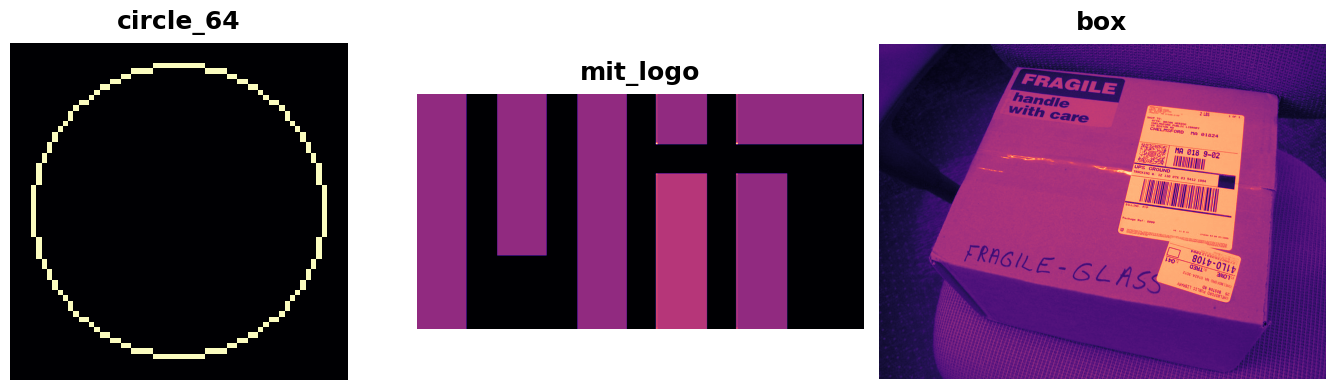

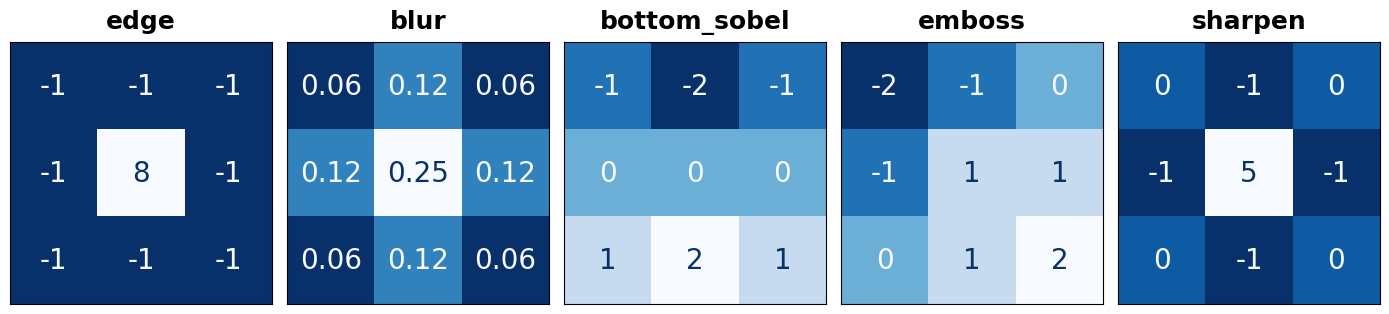

In [67]:
def read_image(path, channels=0):
    image = tf.io.read_file(path)
    image = tf.io.decode_image(image, channels=channels)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image


image_dir = './'
circle_64 = tf.expand_dims(circle([64, 64], val=1.0, r_shrink=4), axis=-1)
mit_logo = read_image(image_dir + str('mit.png'), channels=1)
box = read_image(image_dir + str('box_photo.jpg'), channels=1)
#box = tf.image.resize(box, size=[200, 200])
images = [(circle_64, "circle_64"), (mit_logo, "mit_logo"), (box, "box")]

plt.figure(figsize=(14, 4))
for i, (img, title) in enumerate(images):
    plt.subplot(1, len(images), i+1)
    plt.imshow(tf.squeeze(img))
    plt.axis('off')
    plt.title(title)
plt.show();

kernels = [(edge, "edge"), (blur, "blur"), (bottom_sobel, "bottom_sobel"),
           (emboss, "emboss"), (sharpen, "sharpen")]
plt.figure(figsize=(14, 4))
for i, (krn, title) in enumerate(kernels):
    plt.subplot(1, len(kernels), i+1)
    show_kernel(krn, digits=2, text_size=20)
    plt.title(title)
plt.show()

To choose one to experiment with, just enter it's name in the appropriate place below. Then, set the parameters for the window computation. Try out some different combinations and see what they do!

In [68]:
def show_extraction(image,
                    kernel,
                    conv_stride=1,
                    conv_padding='valid',
                    activation='relu',
                    pool_size=2,
                    pool_stride=2,
                    pool_padding='same',
                    figsize=(10, 10),
                    subplot_shape=(2, 2),
                    ops=['Input', 'Filter', 'Detect', 'Condense'],
                    gamma=1.0):
    # Create Layers
    model = tf.keras.Sequential([
                    tf.keras.layers.Conv2D(
                        filters=1,
                        kernel_size=kernel.shape,
                        strides=conv_stride,
                        padding=conv_padding,
                        use_bias=False,
                        input_shape=image.shape,
                    ),
                    tf.keras.layers.Activation(activation),
                    tf.keras.layers.MaxPool2D(
                        pool_size=pool_size,
                        strides=pool_stride,
                        padding=pool_padding,
                    ),
                   ])

    layer_filter, layer_detect, layer_condense = model.layers
    kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
    layer_filter.set_weights([kernel])

    # Format for TF
    image = tf.expand_dims(image, axis=0)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) 
    
    # Extract Feature
    image_filter = layer_filter(image)
    image_detect = layer_detect(image_filter)
    image_condense = layer_condense(image_detect)
    
    images = {}
    if 'Input' in ops:
        images.update({'Input': (image, 1.0)})
    if 'Filter' in ops:
        images.update({'Filter': (image_filter, 1.0)})
    if 'Detect' in ops:
        images.update({'Detect': (image_detect, gamma)})
    if 'Condense' in ops:
        images.update({'Condense': (image_condense, gamma)})
    
    # Plot
    plt.figure(figsize=figsize)
    for i, title in enumerate(ops):
        image, gamma = images[title]
        plt.subplot(*subplot_shape, i+1)
        plt.imshow(tf.image.adjust_gamma(tf.squeeze(image), gamma))
        plt.axis('off')
        plt.title(title)


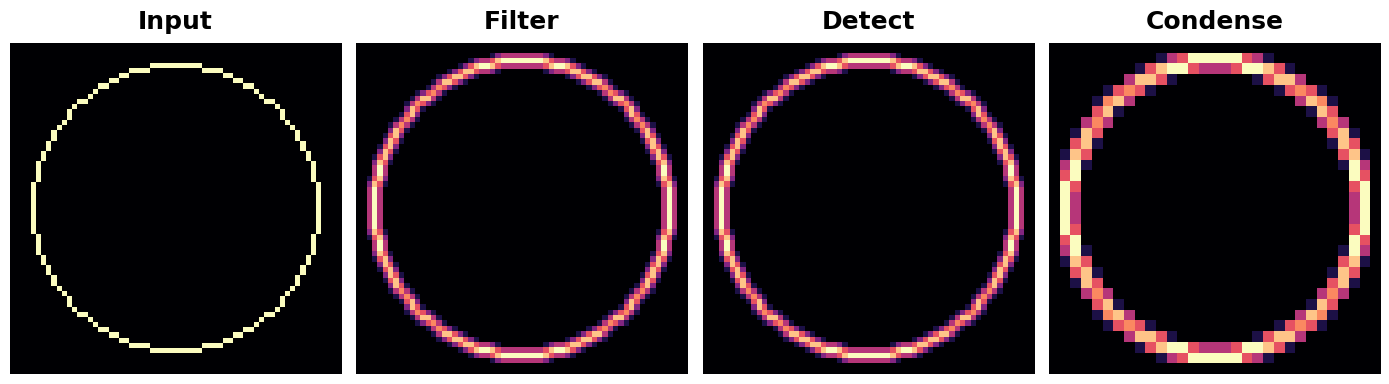

In [71]:
# YOUR CODE HERE: choose an image
image = circle_64

# YOUR CODE HERE: choose a kernel
kernel = blur

show_extraction(
    image, kernel,

    # YOUR CODE HERE: set parameters
    conv_stride=1,
    conv_padding='valid',
    pool_size=2,
    pool_stride=2,
    pool_padding='same',
    
    subplot_shape=(1, 4),
    figsize=(14, 6),
)

### Q: *Describe your findings.*

Please explain your answer in the empty cell below.

Answer: The filters are amazing way to detect the featuers as we say aabove the filter is able to fetext all the blurs in teh circle and the condensed imave makes it clear that is ia circle. however the max pooling depth can distort as we saw earlier. I think it takes time to train and tune the hyper parameters. 